In [1]:
import cv2
import pandas as pd
import numpy as np
import hdbscan
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import spectral_clustering

%matplotlib inline

# STEP 1 : Edge Detection

In [2]:
image = cv2.imread('../File/oil_test_03.jpg')
orig = image.copy()

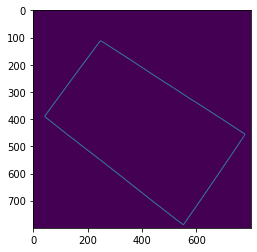

In [3]:
r = 800.0 / image.shape[0]
dim = (int(image.shape[1] * r), 800)
image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (9,9), 0)
edged = cv2.Canny(blur, 70, 150)

plt.imshow(edged)

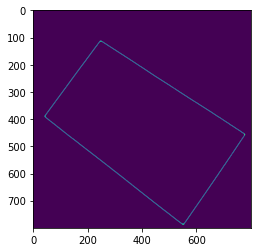

In [4]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
plt.imshow( closed)

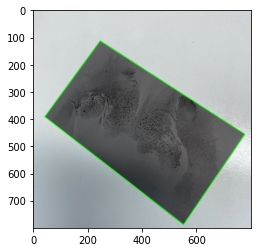

In [5]:
(cnts, _) = cv2.findContours(closed.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

cnts = sorted(cnts, key = cv2.contourArea, reverse=True)[:3]

for c in cnts:
    peri = cv2.arcLength(c,True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    
    if len(approx) == 4:
        screenCnt = approx
        break
        
cv2.drawContours(image,[screenCnt], -1, (0,255,0), 2)

plt.imshow(image)

In [6]:
print(screenCnt)

[[[246 113]]

 [[ 43 391]]

 [[552 787]]

 [[777 455]]]


In [7]:
def order_points(pts):
    rect = np.zeros((4,2), dtype = "float32")
    
    s = pts.sum(axis = 1)
    
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

In [8]:
rect = order_points(screenCnt.reshape(4,2) / r)

(topLeft, topRight, bottomRight, bottomLeft) = rect

w1 = abs(bottomRight[0] - bottomLeft[0])
w2 = abs(topRight[0] - topLeft[0])
h1 = abs(topRight[1] - bottomRight[1])
h2 = abs(topLeft[1] - bottomLeft[1])

In [9]:
maxWidth = max([w1, w2])
maxHeight = max([h1, h2])

In [10]:
dst = np.float32([[0,0], [maxWidth-1,0], [maxWidth-1, maxHeight-1], [0,maxHeight-1]])

In [11]:
M = cv2.getPerspectiveTransform(rect, dst)

In [12]:
warped = cv2.warpPerspective(orig,M,(maxWidth,maxHeight))

<ipython-input-12-c02f6d8c19e2>:1: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  warped = cv2.warpPerspective(orig,M,(maxWidth,maxHeight))


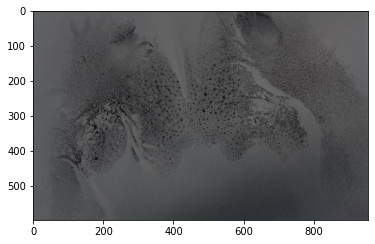

In [13]:
plt.imshow(warped)

In [14]:
warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)

In [15]:
warped = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)

In [16]:
warped = cv2.adaptiveThreshold(warped, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 10)

In [17]:
df = pd.DataFrame(warped)

In [18]:
df

,0,1,2,3,4,5,6,7,8,9,...,792,793,794,795,796,797,798,799,800,801
0,255,255,0,0,0,0,0,0,0,0,...,255,255,255,255,255,255,255,255,255,255
1,255,255,0,0,0,0,0,0,0,255,...,0,0,0,0,0,0,0,0,0,0
2,255,255,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,255,255,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,255,255,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,0,0,0,0,0,0,0,0,0,0,...,255,255,255,255,255,255,255,255,255,0
505,0,0,0,0,0,0,0,0,0,0,...,255,255,255,255,255,255,255,255,255,255
506,0,0,0,0,0,0,0,0,0,0,...,255,255,255,255,255,255,255,255,255,255
507,0,0,0,0,0,0,0,0,0,0,...,255,255,255,255,255,255,255,255,255,255


In [18]:
arr = np.empty((1,2), int)

for i in range(len(df.columns)):
    for j in range(len(df.index)):
        item = np.array([[i,j]])
        arr = np.append(arr,item, axis=0)
arr

array([[9218868437227405312, 9218868437227405312],
       [                  0,                   0],
       [                  0,                   1],
       ...,
       [                954,                 594],
       [                954,                 595],
       [                954,                 596]])

In [19]:
arr.shape

(570136, 2)

In [20]:
arr_y = np.empty((1,), int)

for i in range(len(df.columns)):
    for j in range(len(df.index)):
        item = np.array([df[i][j]])
        arr_y = np.append(arr_y,item, axis=0)
arr_y

array([  0, 255, 255, ..., 255, 255, 255])

In [ ]:
# np.save('../File/dbscan_X_arr.npy', new_X)

In [24]:
# np.save('../File/dbscan_y_arr.npy', y)

In [83]:
# X = np.load('../File/dbscan_X_arr.npy')
# y = np.load('../File/dbscan_y_arr.npy')

In [21]:
for i in range(len(arr_y)):
    if arr_y[i] == 255:
        arr_y[i] = 1

arr_y

array([0, 1, 1, ..., 1, 1, 1])

In [25]:
arr

array([[9218868437227405312, 9218868437227405312],
       [                  0,                   0],
       [                  0,                   1],
       ...,
       [                954,                 594],
       [                954,                 595],
       [                954,                 596]])

In [26]:
arr_y

array([0, 1, 1, ..., 1, 1, 1])

In [27]:
np.where(0 == arr_y)

(array([     0,    232,    263, ..., 570115, 570117, 570128]),)

In [29]:
indexes = []

for i in range(len(arr_y)):
    if arr_y[i] == 1:
        indexes.append(i)
        
indexes

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [30]:
arr = np.delete(arr, indexes, axis = 0)
        
arr

array([[9218868437227405312, 9218868437227405312],
       [                  0,                 231],
       [                  0,                 262],
       ...,
       [                954,                 576],
       [                954,                 578],
       [                954,                 589]])

In [ ]:
arr.shape

In [31]:
arr_y = np.delete(arr_y, indexes, axis = 0)
        
arr_y

array([0, 0, 0, ..., 0, 0, 0])

In [32]:
arr_y

array([0, 0, 0, ..., 0, 0, 0])

In [33]:
X = arr
y = arr_y

In [35]:
X = np.delete(X, 0, axis = 0)
        
X

array([[  0, 231],
       [  0, 262],
       [  0, 267],
       ...,
       [954, 576],
       [954, 578],
       [954, 589]])

In [46]:
np.flip(X, axis = 1)
X

array([[  0, 231],
       [  0, 262],
       [  0, 267],
       ...,
       [954, 576],
       [954, 578],
       [954, 589]])

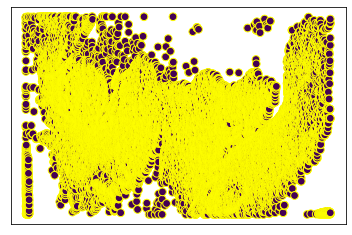

In [36]:
scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)
dbscan = DBSCAN(min_samples=2000, eps=0.05)
clusters = dbscan.fit_predict(X_scaled)

plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', s=60, edgecolors='yellow')
plt.xticks(())
plt.yticks(())
plt.show()

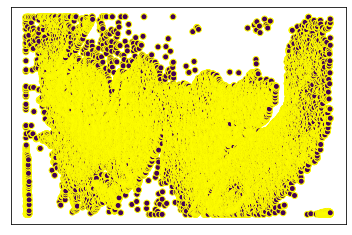

In [37]:
scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)
dbscan = DBSCAN(min_samples=2000, eps=0.05)
clusters = dbscan.fit_predict(X_scaled)

plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', edgecolors='yellow')
plt.xticks(())
plt.yticks(())
plt.show()

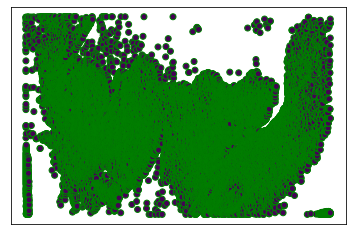

In [38]:
scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)
dbscan = DBSCAN(min_samples=200, eps=0.005)
clusters = dbscan.fit_predict(X_scaled)

plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, edgecolors='green')
plt.xticks(())
plt.yticks(())
plt.show()

In [39]:
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

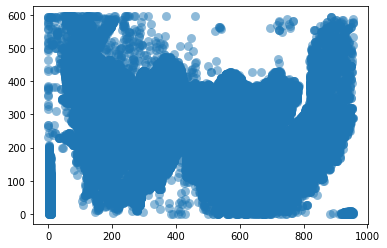

In [41]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=2000, gen_min_span_tree=True)
clusterer.fit(X)

palette = sns.color_palette()
plt.scatter(X.T[0], X.T[1],  **plot_kwds)

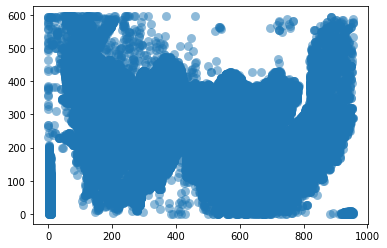

In [42]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=200, gen_min_span_tree=True)
clusterer.fit(X)

palette = sns.color_palette()
plt.scatter(X.T[0], X.T[1],  **plot_kwds)

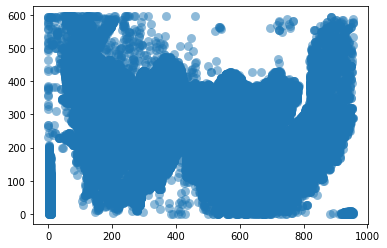

In [43]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=1000)
clusterer.fit(X)

palette = sns.color_palette()
plt.scatter(X.T[0], X.T[1], **plot_kwds)

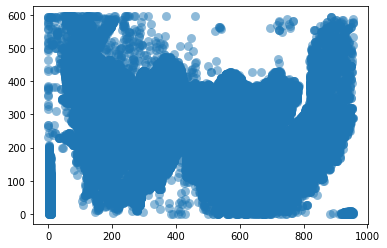

In [48]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=100)
clusterer.fit(X)

palette = sns.color_palette()
plt.scatter(X.T[0], X.T[1],  **plot_kwds)

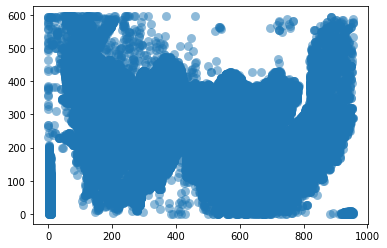

In [49]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=10)
clusterer.fit(X)

palette = sns.color_palette()
plt.scatter(X.T[0], X.T[1], **plot_kwds)

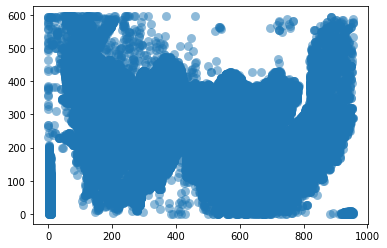

In [51]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=20)
clusterer.fit(X)

palette = sns.color_palette()
plt.scatter(X.T[0], X.T[1],  **plot_kwds)

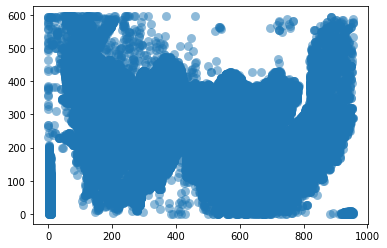

In [52]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=100)
clusterer.fit(X)

plt.scatter(X.T[0], X.T[1], **plot_kwds)